In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import tree, metrics

sns.set_style('whitegrid')
fig_size = plt.rcParams['figure.figsize']

%matplotlib inline

Boolean masks

In [3]:
class Mask:
    def __init__(self, df):
        self.df = df
    
    @property
    def SURVIVED_MASK(self):
        return self.df.Survived == 1
    
    @property
    def NOT_SURVIVED_MASK(self):
        return self.df.Survived == 0
    
    @property
    def CHILDREN_MASK(self):
        return self.df.Age <= 15
    
    @property
    def ADULT_MASK(self):
        return np.logical_and(self.df.Age <= 45, self.df.Age > 15)
    
    @property
    def SENIOR_ADULT_MASK(self):
        return 45 < self.df.Age
    
    @property
    def MALE_MASK(self):
        return self.df.Sex == 'male'
    
    @property
    def FEMALE_MASK(self):
        return self.df.Sex == 'female'
    
    @property
    def FIRST_CLASS_MASK(self):
        return self.df.Pclass == 1
    
    @property
    def SECOND_CLASS_MASK(self):
        return self.df.Pclass == 2
    
    @property
    def THIRD_CLASS_MASK(self):
        return self.df.Pclass == 3

Helper functions

In [4]:
def label_age_group(x: float) -> str:
    if x <= 15:
        return "Child"
    if x < 45:
        return "Adult"
    return "SeniorAdult"


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    # filling age missing values with median
    df['Age'] = df.Age.fillna(df.Age.median())
    
    # grouping age values
    df['AgeGroup'] = df.Age.apply(label_age_group)

    return df

In [5]:
TRAIN_FILE = "/kaggle/input/titanic/train.csv"
TEST_FILE = "/kaggle/input/titanic/test.csv"
SUBMISSION_FILE = "/kaggle/input/titanic/gender_submission.csv"

In [6]:
train_df = pd.read_csv(TRAIN_FILE).drop(["Cabin", "Embarked"], axis=1)
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500


In [7]:
# Preprocessing
train_df = preprocess_data(train_df)
train_mask = Mask(train_df)

# It's EDA time...

### How does survivability depend on Pclass?

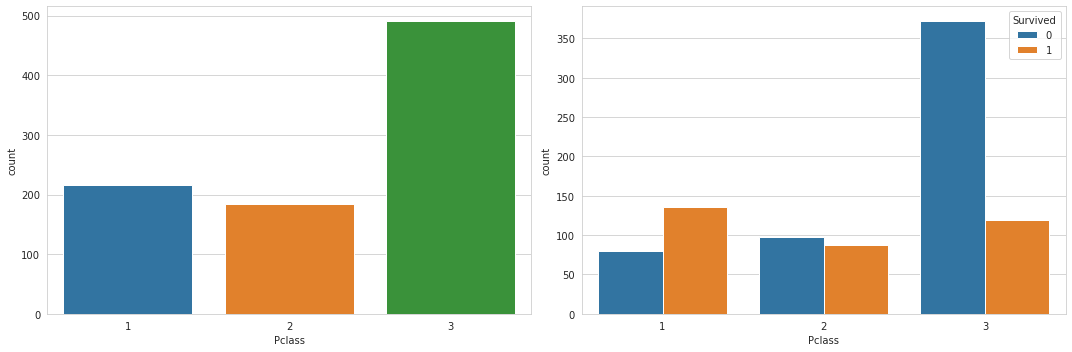

In [8]:
nrows=1
ncols = 2
column = "Pclass"
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols * 1.25, fig_size[1] * nrows * 1.25))
_ = sns.countplot(x=column, data=train_df, ax=ax[0])
_ = sns.countplot(x=column, hue="Survived", data=train_df, ax=ax[1])
_ = plt.tight_layout()

We see that there are way more 3rd class passengers than 1st or 2nd class. But when it separated according to the Survived label, it is clear that 1st class was given more priority over 2nd and 3rd classes to escort out of the crash.


<!-- We see that most of the 1st class passengers survived. On the contrary, a handful of the 3rd class passengers survived. Since, there is a clear dependence of Survival probability on the Pclass, Pclass can be considered as a feature.<br>
<br>
Relationship:<br>
Higher the class of the passenger, higher the probability of survival -->

### How does survivability depend on Gender?

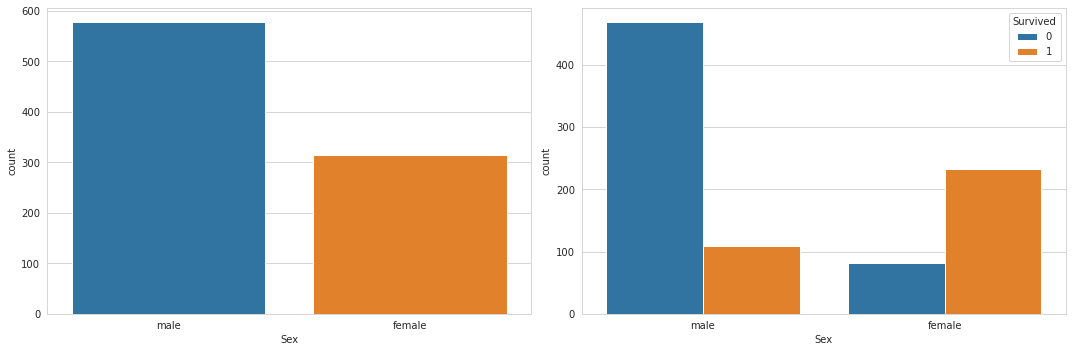

In [9]:
nrows=1
ncols = 2
column = "Sex"
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols * 1.25, fig_size[1] * nrows * 1.25))
_ = sns.countplot(x=column, data=train_df, ax=ax[0])
_ = sns.countplot(x=column, hue="Survived", data=train_df, ax=ax[1])
_ = plt.tight_layout()

We see a similar relationship as with Pclass. The women were given higher priority to escort to safety than the men. This clear influence that the variable has over the target label Survived helps us decide whether or not this variable should be considered as a feature.

### How does survivability depend on Age?

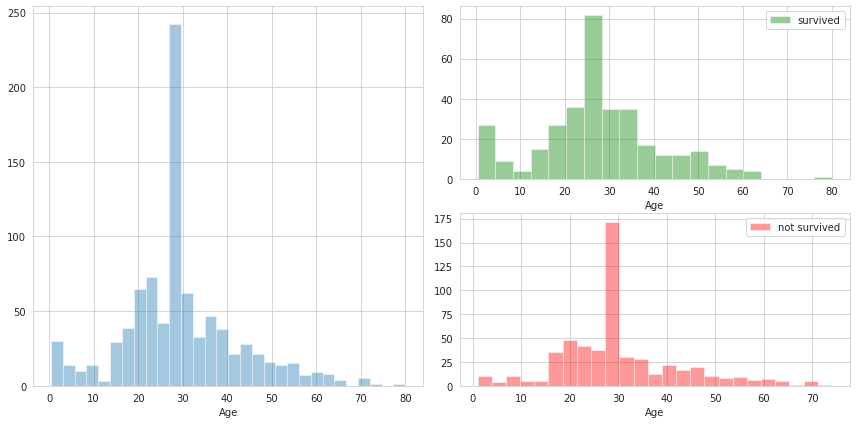

In [10]:
fig = plt.figure(figsize=(fig_size[0] * 2, fig_size[1] * 1.5))

gs0 = gridspec.GridSpec(1, 2, figure=fig)
ax0 = fig.add_subplot(gs0[0, 0])
gs01 = gs0[0, 1].subgridspec(2, 1)
ax1 = fig.add_subplot(gs01[0, 0])
ax2 = fig.add_subplot(gs01[1, 0])

_ = sns.distplot(train_df.Age, ax=ax0, kde=False)
_ = ax0.set_xlabel("Age")
_ = sns.distplot(train_df.loc[train_mask.SURVIVED_MASK].Age, ax=ax1, label='survived', kde=False, color='green')
_ = sns.distplot(train_df.loc[train_mask.NOT_SURVIVED_MASK].Age, ax=ax2, label='not survived', kde=False, color='red')
_ = ax1.legend()
_ = ax2.legend()
_ = plt.tight_layout()

The left half is the distribution of all the values in the `Age` column. The right half has two distplots of those who survived and those who did not.

We can divide the values of the `Age` column into three buckets:
1. Children (Age <= 15)
2. Adults (15 < Age <= 40)
3. Senior Adults (Age > 40)

We see that most of the children survived than the adults and senior adults.


To make visualisation easier, I will label each row with one of "Child", "Adult", "SeniorAdult" depending on their age.

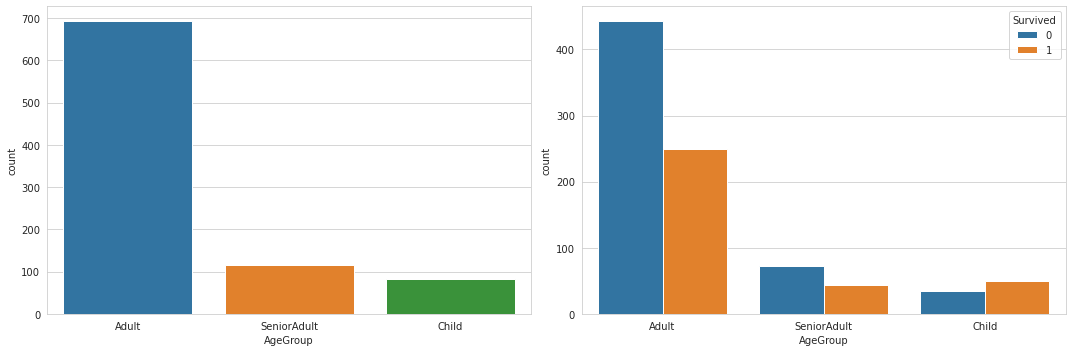

In [11]:
nrows=1
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols * 1.25, fig_size[1] * nrows * 1.25))
_ = sns.countplot(x="AgeGroup", data=train_df, ax=ax[0])
_ = sns.countplot(x="AgeGroup", data=train_df, hue=train_df.Survived, ax=ax[1])
_ = plt.tight_layout()

In [12]:
print(f"Children that survived = {train_df.loc[np.logical_and(train_mask.SURVIVED_MASK, train_mask.CHILDREN_MASK)].shape[0]}")
print(f"Children that did not survive = {train_df.loc[np.logical_and(train_mask.NOT_SURVIVED_MASK, train_mask.CHILDREN_MASK)].shape[0]}")
print()
print(f"Adults that survived = {train_df.loc[np.logical_and(train_mask.SURVIVED_MASK, train_mask.ADULT_MASK)].shape[0]}")
print(f"Adults that did not survive = {train_df.loc[np.logical_and(train_mask.NOT_SURVIVED_MASK, train_mask.ADULT_MASK)].shape[0]}")
print()
print(f"Senior adults that survived = {train_df.loc[np.logical_and(train_mask.SURVIVED_MASK, train_mask.SENIOR_ADULT_MASK)].shape[0]}")
print(f"Senior adults that did not survive = {train_df.loc[np.logical_and(train_mask.NOT_SURVIVED_MASK, train_mask.SENIOR_ADULT_MASK)].shape[0]}")

Children that survived = 49
Children that did not survive = 34

Adults that survived = 255
Adults that did not survive = 450

Senior adults that survived = 38
Senior adults that did not survive = 65


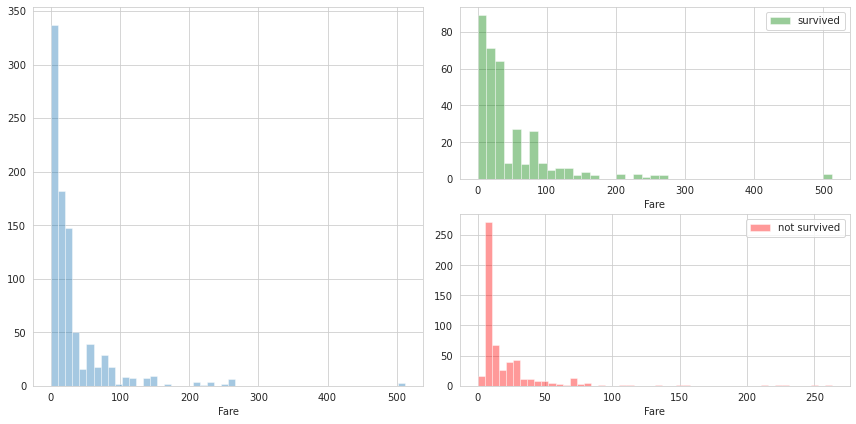

In [13]:
fig = plt.figure(figsize=(fig_size[0] * 2, fig_size[1] * 1.5))

gs0 = gridspec.GridSpec(1, 2, figure=fig)
ax0 = fig.add_subplot(gs0[0, 0])
gs01 = gs0[0, 1].subgridspec(2, 1)
ax1 = fig.add_subplot(gs01[0, 0])
ax2 = fig.add_subplot(gs01[1, 0])

_ = sns.distplot(train_df.Fare.values, ax=ax0, kde=False)
_ = ax0.set_xlabel("Fare")
_ = sns.distplot(train_df.loc[train_mask.SURVIVED_MASK].Fare, ax=ax1, label='survived', kde=False, color='green')
_ = sns.distplot(train_df.loc[train_mask.NOT_SURVIVED_MASK].Fare, ax=ax2, label='not survived', kde=False, color='red')
_ = ax1.legend()
_ = ax2.legend()
_ = plt.tight_layout()

Not much can be understood from this plot other than that the passengers with expensive tickets survived.<br>
This is probably because First class tickets are more expensive, and we know that First class passengers were given more priority in escaping to safety.

We can verify this by plotting the Fare values of each Pclass separately.

#### Plotting Fare values for each Pclass

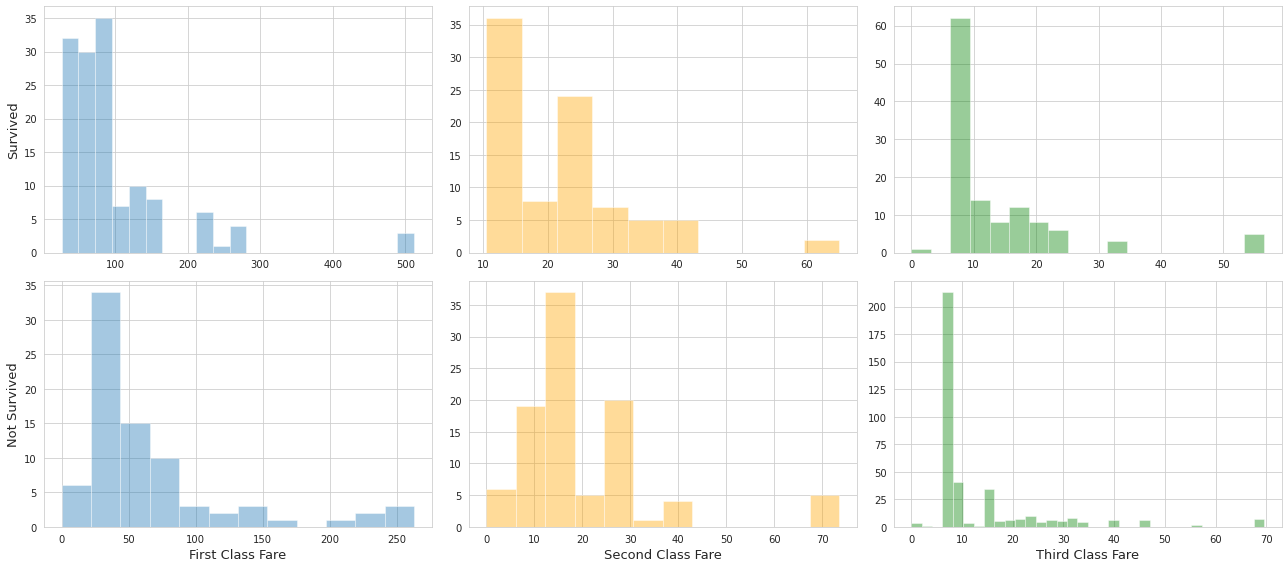

In [14]:
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols, fig_size[1] * nrows))
_ = sns.distplot(train_df.loc[np.logical_and(train_mask.FIRST_CLASS_MASK, train_mask.SURVIVED_MASK)].Fare, kde=False, ax=ax[0, 0])
_ = sns.distplot(train_df.loc[np.logical_and(train_mask.SECOND_CLASS_MASK, train_mask.SURVIVED_MASK)].Fare, kde=False, ax=ax[0, 1], color='orange')
_ = sns.distplot(train_df.loc[np.logical_and(train_mask.THIRD_CLASS_MASK, train_mask.SURVIVED_MASK)].Fare, kde=False, ax=ax[0, 2], color='green')
_ = sns.distplot(train_df.loc[np.logical_and(train_mask.FIRST_CLASS_MASK, train_mask.NOT_SURVIVED_MASK)].Fare, kde=False, ax=ax[1, 0])
_ = sns.distplot(train_df.loc[np.logical_and(train_mask.SECOND_CLASS_MASK, train_mask.NOT_SURVIVED_MASK)].Fare, kde=False, ax=ax[1, 1], color='orange')
_ = sns.distplot(train_df.loc[np.logical_and(train_mask.THIRD_CLASS_MASK, train_mask.NOT_SURVIVED_MASK)].Fare, kde=False, ax=ax[1, 2], color='green')
_ = ax[0, 0].set_xlabel("")
_ = ax[0, 1].set_xlabel("")
_ = ax[0, 2].set_xlabel("")
_ = ax[1, 0].set_xlabel("First Class Fare", fontsize=13)
_ = ax[1, 1].set_xlabel("Second Class Fare", fontsize=13)
_ = ax[1, 2].set_xlabel("Third Class Fare", fontsize=13)
_ = ax[0, 0].set_ylabel("Survived", fontsize=13)
_ = ax[1, 0].set_ylabel("Not Survived", fontsize=13)

_ = plt.tight_layout()

By plotting the distribution of the Class-wise Fare for Survived and Not Survived passengers, we see that in the case of First Class, the passengers with the most expensive tickets survived, meaning they were given priority in escaping to safety.

# Building the model

## Data Preparation
Before building the model, we must prepare the data to feed into the model.

In [15]:
# Gathering
input_cols = ["Pclass", "Sex", "AgeGroup", "Fare"]
target_cols = ["Survived"]

input_data = train_df.loc[:, input_cols]
target_data = train_df.loc[:, target_cols].values

input_data = pd.get_dummies(input_data)
input_dummies = input_data.values

## Training the model

In [16]:
# Intialize the classifier
dtc = tree.DecisionTreeClassifier()

# Train the classifier with our training data
dtc = dtc.fit(input_dummies, target_data)

# Save the model in a pickle file
with open('titanic_decision_tree_model.pkl', mode='wb') as f:
    pickle.dump(dtc, f)

### Evaluating the performance of the model

Accuracy: 92.26%
Precision: 0.94
Recall: 0.85
F1-Score: 0.89


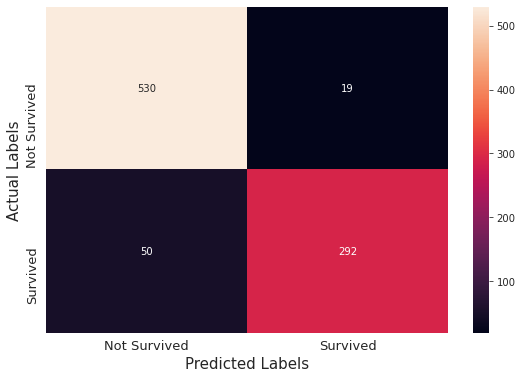

In [17]:
y_pred = dtc.predict(input_dummies)
y_true = np.squeeze(target_data.T)

accuracy = sum(y_pred == y_true) / y_pred.shape[0]
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

scale = 1.5
_ = plt.figure(figsize=(fig_size[0] * scale, fig_size[1] * scale))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d')
_ = ax.set_xticklabels(["Not Survived", "Survived"], fontsize=13)
_ = ax.set_yticklabels(["Not Survived", "Survived"], fontsize=13)
_ = ax.set_xlabel("Predicted Labels", fontsize=15)
_ = ax.set_ylabel("Actual Labels", fontsize=15)

A text representation of the tree model

In [18]:
tree_text = tree.export_text(dtc, feature_names=list(input_data.columns))
print(tree_text)
with open("titanic_decision_tree_text.log", mode='w') as f:
    f.write(tree_text)

|--- Sex_male <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- Fare <= 28.86
|   |   |   |--- Fare <= 28.23
|   |   |   |   |--- Fare <= 26.12
|   |   |   |   |   |--- AgeGroup_Child <= 0.50
|   |   |   |   |   |   |--- Fare <= 25.96
|   |   |   |   |   |   |   |--- Fare <= 22.00
|   |   |   |   |   |   |   |   |--- Fare <= 20.25
|   |   |   |   |   |   |   |   |   |--- Fare <= 13.25
|   |   |   |   |   |   |   |   |   |   |--- AgeGroup_SeniorAdult <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- AgeGroup_SeniorAdult >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- Fare >  13.25
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- Fare >  20.25
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- Fare >  22.00
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Fa

In [19]:
# scale = 2.5
# fig = plt.figure(figsize=(fig_size[0] * scale, fig_size[1] * scale))

# _ = tree.plot_tree(dtc, filled=True)
import graphviz
dot = tree.export_graphviz(dtc, out_file=None, filled=True, feature_names=list(input_data.columns), class_names=["Not Survived", "Survived"])
graph = graphviz.Source(dot, format='svg')
_ = graph.render('titanic_decision_tree_graphviz')

*The depth of the tree is 21, which makes it difficult to render in the notebook.*

# Predicting on the test data set

In [20]:
test_df = pd.read_csv(TEST_FILE).drop(["Cabin", "Embarked"], axis=1)
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
dtypes: float64(2), int64(4), object(3)
memory usage: 29.5+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875


Preprocess data

In [21]:
test_df = preprocess_data(test_df)
test_mask = Mask(test_df)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   AgeGroup     418 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 32.8+ KB


We see that Fare still has a missing value.

I'll fill this in with the average value of the Pclass it belongs to.

In [22]:
test_df.loc[test_df.Fare.isnull(), :]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,AgeGroup
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,SeniorAdult


The missing value for Fare is from Pclass 3, so I'll fill it with the average fare of Pclass 3.

In [23]:
test_df.loc[test_df.Fare.isnull(), "Fare"] = test_df.loc[test_mask.THIRD_CLASS_MASK].Fare.mean()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   AgeGroup     418 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 32.8+ KB


Gather the input data to feed into the model

In [24]:
# Gathering
test_input_cols = ["Pclass", "Sex", "AgeGroup", "Fare"]

test_input_data = test_df.loc[:, test_input_cols]

test_input_data = pd.get_dummies(test_input_data)
test_input_dummies = test_input_data.values
test_input_data

,Pclass,Fare,Sex_female,Sex_male,AgeGroup_Adult,AgeGroup_Child,AgeGroup_SeniorAdult
0,3,7.8292,0,1,1,0,0
1,3,7.0000,1,0,0,0,1
2,2,9.6875,0,1,0,0,1
3,3,8.6625,0,1,1,0,0
4,3,12.2875,1,0,1,0,0
...,...,...,...,...,...,...,...
413,3,8.0500,0,1,1,0,0
414,1,108.9000,1,0,1,0,0
415,3,7.2500,0,1,1,0,0
416,3,8.0500,0,1,1,0,0


In [25]:
# Feeding the test data to the model
y_pred_test = dtc.predict(test_input_dummies)

In [26]:
# Logging the predictions into the submission file
submission_df = pd.read_csv(SUBMISSION_FILE)
submission_df.Survived = y_pred_test
submission_df.set_index(['PassengerId']).to_csv("submission.csv")